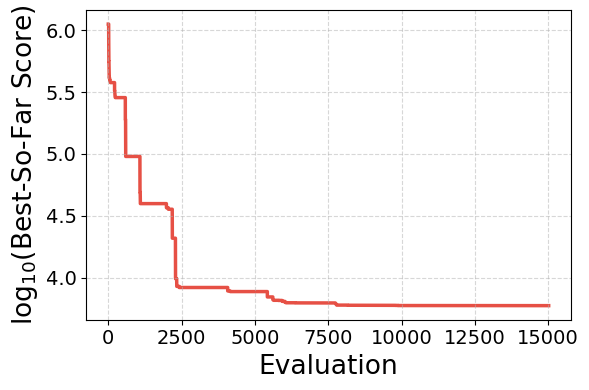

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO

# === 1. Load Data from dumpfile.dat ===
filename = "dumpfile.dat"
penalty_threshold = 1e10  # Penalty threshold

try:
    # Read the file. We use the python engine to handle the separator flexibility
    # Assumes format: Params | Score | Aux...
    df_raw = pd.read_csv(
        filename, 
        sep=r'\s*\|\s*', 
        header=None, 
        engine='python',
        usecols=[1], # We only need column index 1 (the score)
        names=['score']
    )
    
    # Add iteration column (0, 1, 2...) and a dummy 'run' column to match your logic
    df_raw['iteration'] = df_raw.index + 1
    df_raw['run'] = 'run_1' 
    
    detailed_df = df_raw

except FileNotFoundError:
    print(f"Error: '{filename}' not found.")
    detailed_df = pd.DataFrame() # Empty to prevent crash

# === 2. Logic: Process Data (Your Provided Logic) ===
if not detailed_df.empty:
    detailed_df = detailed_df.sort_values(by=["run", "iteration"])
    best_so_far_dict = {}

    for run, group in detailed_df.groupby("run"):
        scores = group["score"].values
        iterations = group["iteration"].values

        # Mask penalty values
        valid_mask = scores < penalty_threshold
        valid_scores = scores[valid_mask]
        valid_iterations = iterations[valid_mask]

        if len(valid_scores) == 0:
            continue

        # Calculate Best So Far (Cumulative Minimum)
        best_so_far = np.minimum.accumulate(valid_scores)
        best_so_far_dict[run] = pd.Series(best_so_far, index=valid_iterations)

    # Combine and interpolate (Useful if you eventually add multiple files/runs)
    if best_so_far_dict:
        best_so_far_df = pd.DataFrame(best_so_far_dict)
        best_so_far_df = best_so_far_df.sort_index().interpolate(method='linear', axis=0)

        # Compute statistics (Mean and Std across runs - trivial for single run but keeps logic)
        mean_best = best_so_far_df.mean(axis=1)
        std_best = best_so_far_df.std(axis=1)
        
        # Fill NaN std with 0 (happens if only 1 run exists)
        std_best = std_best.fillna(0) 

        # === 3. Apply log10 for plotting ===
        # Handle negative or zero values safely before log
        if (mean_best <= 0).any():
             print("Warning: Data contains non-positive values. Log10 plot may be invalid.")
             
        log_mean_best = np.log10(mean_best)
        
        # Propagate std error in log scale (avoid division by zero if mean is 0)
        with np.errstate(divide='ignore', invalid='ignore'):
             log_std_best = std_best / (mean_best * np.log(10))
             log_std_best = log_std_best.fillna(0)

        # === 4. Plot ===
        fig, ax1 = plt.subplots(figsize=(6, 4))

        ax1.plot(log_mean_best.index, log_mean_best.values, label="log₁₀(Best-So-Far)", color="#E65045", linewidth=2.5, zorder=0)
        
        # Only fill between if there is actual deviation (requires >1 run)
        if not std_best.eq(0).all():
            ax1.fill_between(log_mean_best.index,
                             log_mean_best - log_std_best,
                             log_mean_best + log_std_best,
                             color="#E65045", alpha=0.3, zorder=0)

        # Axis labels
        ax1.set_xlabel("Evaluation", fontsize=19)
        ax1.set_ylabel(r"log$_{10}$(Best-So-Far Score)", fontsize=19)
        ax1.tick_params(labelsize=14)
        ax1.grid(True, linestyle='--', alpha=0.5)

        plt.tight_layout()
        plt.show() # Show in notebook
        # plt.savefig("best_so_far_filtered_log.png", dpi=300, bbox_inches='tight')
        
    else:
        print("No valid scores below penalty threshold found.")